# Enhanced Credit Card Fraud Detection

## 1. Library Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Core ML libraries
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score)


In [3]:
# Sampling technique
from imblearn.over_sampling import SMOTE

In [4]:
# XGBoost
import xgboost as xg
from xgboost import XGBClassifier

In [5]:
# Feature engineering
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
import datetime as dt

In [6]:
# SHAP for feature importance
import shap
SHAP_AVAILABLE = True
print("SHAP library loaded successfully")

SHAP library loaded successfully


In [7]:
# Parallel processing
from joblib import Parallel, delayed

## 2. Data Loading and Preview

In [8]:
# Set display options
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)

In [9]:
# Load datasets
train_file_path = 'fraudTrain.csv'
test_file_path = 'fraudTest.csv'

In [10]:
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (1296675, 23)
Test data shape: (555719, 23)


In [11]:
# Rename unnamed column
train_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
test_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

## 3. Data Quality Assessment

In [12]:
print("\nBasic Dataset Information:")
print(f"Training set: {train_data.shape[0]:,} transactions")
print(f"Test set: {test_data.shape[0]:,} transactions")
print(f"Fraud rate in training: {train_data['is_fraud'].mean():.3%}")
print(f"Fraud rate in test: {test_data['is_fraud'].mean():.3%}")


Basic Dataset Information:
Training set: 1,296,675 transactions
Test set: 555,719 transactions
Fraud rate in training: 0.579%
Fraud rate in test: 0.386%


0.5% (7506/1289169) of train data and 0.4%(2145/553574) of test data are fraudulent transactions - There is a class **imbalanced** issue, and upsampling is required.

In [13]:
def comprehensive_data_quality_check(df, name):
    """Enhanced data quality assessment"""
    print(f"\n=== {name} Data Quality Report ===")
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        print(f"\nMissing values found:")
        print(missing_data[missing_data > 0])
    else:
        print("No missing values")
    
    # Duplicate analysis
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")
    
    # Target variable analysis
    if 'is_fraud' in df.columns:
        fraud_rate = df['is_fraud'].mean()
        print(f"\nFraud rate: {fraud_rate:.3%}")
        print(f"Class imbalance ratio: {(1-fraud_rate)/fraud_rate:.1f}:1")
    
    return {
        'missing_values': missing_data.sum(),
        'duplicates': duplicates,
        'fraud_rate': df['is_fraud'].mean() if 'is_fraud' in df.columns else None
    }


In [14]:
# Run quality checks
train_quality = comprehensive_data_quality_check(train_data, "Training")
test_quality = comprehensive_data_quality_check(test_data, "Test")


=== Training Data Quality Report ===
Shape: (1296675, 23)
Memory usage: 1034.99 MB
No missing values
No missing values
Duplicate rows: 0

Fraud rate: 0.579%
Class imbalance ratio: 171.8:1

=== Test Data Quality Report ===
Shape: (555719, 23)
Duplicate rows: 0

Fraud rate: 0.579%
Class imbalance ratio: 171.8:1

=== Test Data Quality Report ===
Shape: (555719, 23)
Memory usage: 443.58 MB
No missing values
Memory usage: 443.58 MB
No missing values
Duplicate rows: 0

Fraud rate: 0.386%
Class imbalance ratio: 258.1:1
Duplicate rows: 0

Fraud rate: 0.386%
Class imbalance ratio: 258.1:1


Based on the data quality repport, there is no row with missing values or duplicated records. So we only need to resolve the class imbalance issue.

## 4. Advanced Feature Engineering

In [15]:
def extract_temporal_features(df):
    """Enhanced temporal feature extraction"""
    df = df.copy()
    
    # Convert datetime columns
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    
    # Extract basic temporal features
    df['trans_month'] = df['trans_date_trans_time'].dt.month
    df['trans_day'] = df['trans_date_trans_time'].dt.day_name()
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_weekday'] = df['trans_date_trans_time'].dt.weekday
    
    # Advanced temporal features
    df['is_weekend'] = df['trans_weekday'].isin([5, 6]).astype(int)
    df['is_night'] = df['trans_hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    df['is_business_hours'] = df['trans_hour'].isin(range(9, 17)).astype(int)
    
    # Seasonal features
    df['quarter'] = df['trans_date_trans_time'].dt.quarter
    df['is_holiday_season'] = df['trans_month'].isin([11, 12]).astype(int)
    df['is_tax_season'] = df['trans_month'].isin([1, 2, 3, 4]).astype(int)
    
    # Time-based cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['trans_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['trans_hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['trans_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['trans_month'] / 12)
    
    return df

In [16]:
def extract_demographic_features(df):
    """Enhanced demographic feature extraction"""
    df = df.copy()
    
    # Calculate age
    ref_date = pd.to_datetime('2021-01-01')
    df['age'] = (ref_date - df['dob']).dt.days // 365
    
    # Age groups with more granularity
    df['age_group'] = pd.cut(df['age'], 
                           bins=[0, 18, 25, 35, 50, 65, 100], 
                           labels=['minor', 'young_adult', 'adult', 'middle_aged', 'senior', 'elderly'])
    
    # Gender encoding
    df['gender_encoded'] = df['gender'].map({'M': 1, 'F': 0})
    
    return df

In [17]:
def extract_geographic_features(df):
    """Enhanced geographic feature extraction"""
    df = df.copy()
    
    # City population categories
    df['city_pop_category'] = pd.cut(df['city_pop'],
                                   bins=[0, 10000, 50000, 100000, 500000, 1000000, np.inf],
                                   labels=['rural', 'small_town', 'town', 'small_city', 'city', 'major_city'])
    
    # Distance between cardholder and merchant
    def haversine_distance(lat1, lon1, lat2, lon2): 
        R = 6371  # Earth's radius in kilometers
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    
    df['distance_km'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    df['is_distant_transaction'] = (df['distance_km'] > 100).astype(int)
    
    return df

I used haversine formula to calculate distance between merchants and transactions based on latitude and longitude, thi is a benchmark that can be used to identify ehether the current card holder is registered locally.

In [ ]:
# def create_interaction_features(df, key_features=['amt', 'age', 'trans_hour', 'city_pop']):
#     """Create interaction features between key variables"""
#     df = df.copy()
    
#     # Select only numeric features that exist
#     available_features = [f for f in key_features if f in df.columns and df[f].dtype in ['int64', 'float64']]
    
#     for feat1, feat2 in combinations(available_features, 2):
#         df[f'{feat1}_x_{feat2}'] = df[feat1] * df[feat2]
    
#     return df

By capturing interactions between key variables, we can help the model identify complex relationships and improve predictive performance.

In [18]:
# Apply feature engineering
print("\nApplying enhanced feature engineering...")

train_data_enhanced = extract_temporal_features(train_data)
train_data_enhanced = extract_demographic_features(train_data_enhanced)
train_data_enhanced = extract_geographic_features(train_data_enhanced)

test_data_enhanced = extract_temporal_features(test_data)
test_data_enhanced = extract_demographic_features(test_data_enhanced)
test_data_enhanced = extract_geographic_features(test_data_enhanced)

print(f"Enhanced training data shape: {train_data_enhanced.shape}")
print(f"Enhanced test data shape: {test_data_enhanced.shape}")


Applying enhanced feature engineering...
Enhanced training data shape: (1296675, 43)
Enhanced test data shape: (555719, 43)
Enhanced training data shape: (1296675, 43)
Enhanced test data shape: (555719, 43)


In [19]:
def create_fraud_analysis_plots(train_enhanced):
    """Create comprehensive fraud analysis visualizations"""
    fraud_data = train_enhanced[train_enhanced['is_fraud'] == 1]
    normal_data = train_enhanced[train_enhanced['is_fraud'] == 0]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Amount distribution
    axes[0,0].hist(normal_data['amt'], bins=50, alpha=0.7, label='Normal', density=True)
    axes[0,0].hist(fraud_data['amt'], bins=50, alpha=0.7, label='Fraud', density=True)
    axes[0,0].set_xlabel('Transaction Amount')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Transaction Amount Distribution')
    axes[0,0].legend()
    axes[0,0].set_xlim(0, 1000)
    
    # Hourly patterns
    hour_fraud = fraud_data['trans_hour'].value_counts().sort_index()
    hour_normal = normal_data['trans_hour'].value_counts().sort_index()
    hour_fraud_rate = hour_fraud / (hour_fraud + hour_normal)
    
    sns.barplot(x=hour_fraud_rate.index, y=hour_fraud_rate.values, ax=axes[0,1], palette='rocket_r')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Fraud Rate')
    axes[0,1].set_title('Fraud Rate by Hour')
    
    # Age group analysis
    age_fraud = pd.crosstab(train_enhanced['age_group'], train_enhanced['is_fraud'], normalize='index')
    sns.barplot(x=age_fraud.index, y=age_fraud[1].values, ax=axes[0,2], palette='Paired')
    axes[0,2].set_xlabel('Age Group')
    axes[0,2].set_ylabel('Fraud Rate')
    axes[0,2].set_title('Fraud Rate by Age Group')
    
    # Distance analysis
    axes[1,0].hist(normal_data['distance_km'], bins=50, alpha=0.7, label='Normal', density=True)
    axes[1,0].hist(fraud_data['distance_km'], bins=50, alpha=0.7, label='Fraud', density=True)
    axes[1,0].set_xlabel('Distance (km)')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Distance Distribution')
    axes[1,0].legend()
    axes[1,0].set_xlim(0, 500)
    
    # Monthly distribution
    month_fraud = fraud_data['trans_month'].value_counts().sort_index()
    month_normal = normal_data['trans_month'].value_counts().sort_index()
    month_fraud_rate = month_fraud / (month_fraud + month_normal)
    
    sns.barplot(x=month_fraud_rate.index, y=month_fraud_rate.values, ax=axes[1,1], palette='viridis')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Fraud Rate')
    axes[1,1].set_title('Fraud Rate by Month')
    
    # Gender distribution
    gender_fraud = pd.crosstab(train_enhanced['gender'], train_enhanced['is_fraud'], normalize='index')
    sns.barplot(x=gender_fraud.index, y=gender_fraud[1].values, ax=axes[1,2], palette='Set2')
    axes[1,2].set_xlabel('Gender')
    axes[1,2].set_ylabel('Fraud Rate')
    axes[1,2].set_title('Fraud Rate by Gender')
    
    plt.tight_layout()
    plt.savefig("eda_viz/fraud_analysis_plots.png")
    plt.show()


Creating fraud analysis visualizations...


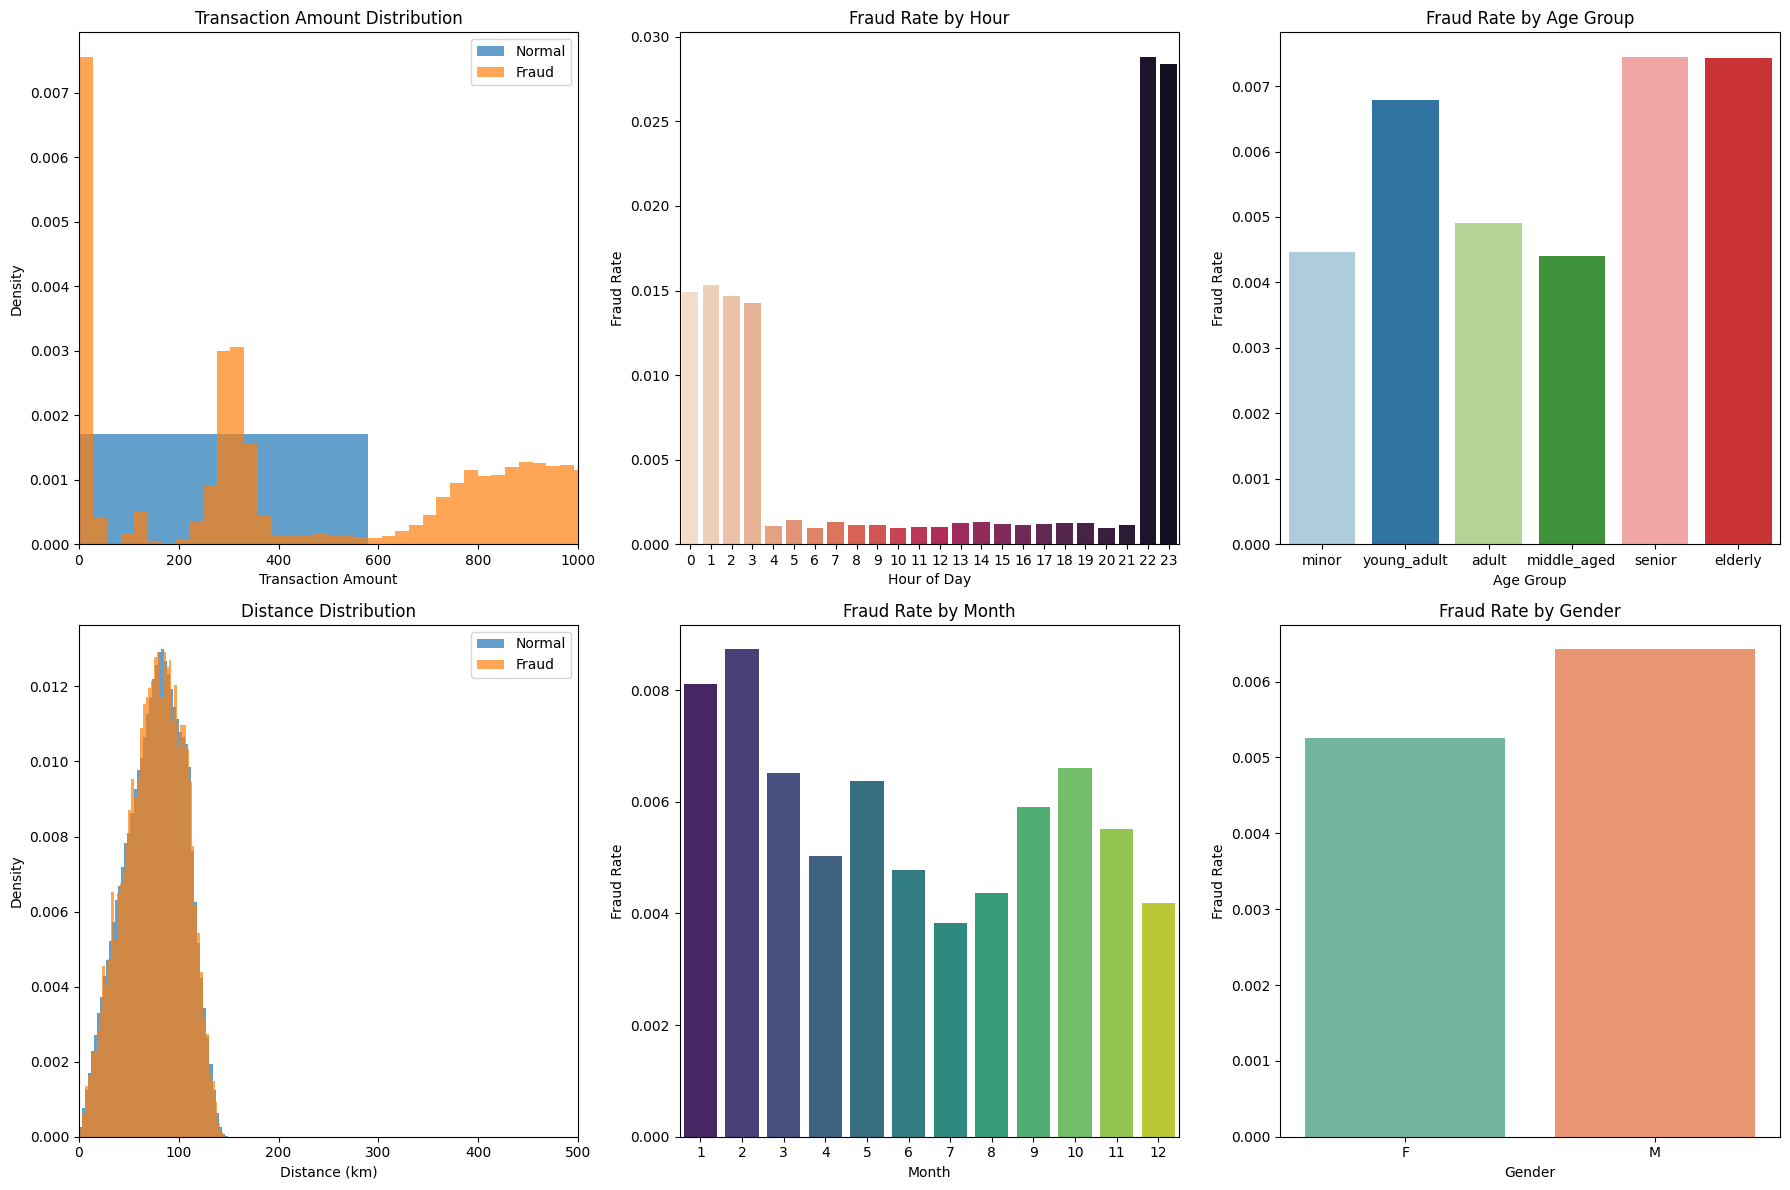

In [20]:
# Create and save EDA visualizations
print("\nCreating fraud analysis visualizations...")
create_fraud_analysis_plots(train_data_enhanced)

In [21]:
def plot_correlation_matrix(train_enhanced):
    """Plot correlation matrix for numeric features"""
    numeric_data = train_enhanced.select_dtypes(include=[np.number])
    
    plt.figure(figsize=(16, 12))
    corr_matrix = numeric_data.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
                square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix - Numeric Features')
    plt.tight_layout()
    plt.savefig("eda_viz/correlation_matrix.png")
    plt.show()


Creating correlation matrix...


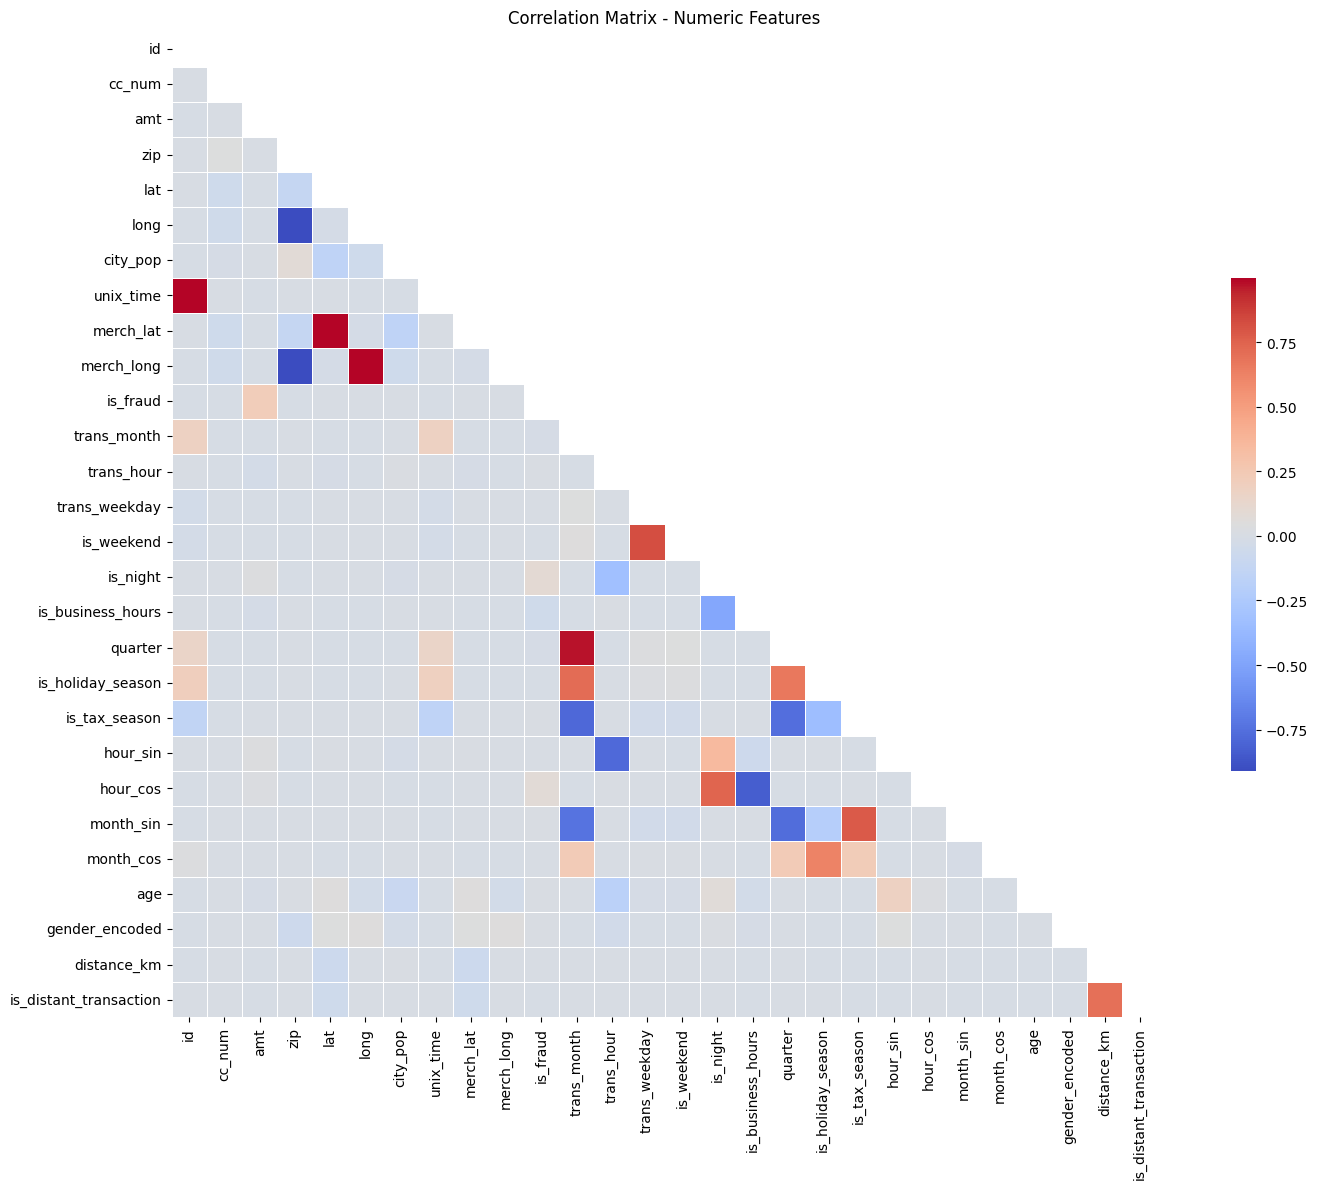

In [22]:
# Create and save correlation matrix
print("\nCreating correlation matrix...")
plot_correlation_matrix(train_data_enhanced)

Based on the correlation matrix of numeric features, I can see there are some reasonable strong correlations between certain features (i.e. longtitude and latitudde, quarter and month), other features are not stronly correlated. Now we need to apply VIF to eliminate feature with VIF > 10 (high multicollinearity).

In [23]:
X = train_data_enhanced.select_dtypes(include=[np.number]).drop('is_fraud', axis=1)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                   Feature       VIF
0                       id  1.034157
1                   cc_num  1.007116
2                      amt  1.000039
3                      zip  1.007997
4                      lat  1.039400
5                     long  5.816183
6                 city_pop  1.006350
7                unix_time  0.000690
8                merch_lat  1.038898
9               merch_long  5.766847
10             trans_month  1.034337
11              trans_hour  1.000424
12           trans_weekday  1.001015
13              is_weekend  1.000729
14                is_night  1.000085
15       is_business_hours  1.000019
16                 quarter  1.023506
17       is_holiday_season  1.042258
18           is_tax_season  1.019132
19                hour_sin  1.000452
20                hour_cos  1.000015
21               month_sin  0.999997
22               month_cos  1.001286
23                     age  1.008681
24          gender_encoded  1.004941
25             distance_km  1.000161
2

## 5. Data Preprocessing and SMOTE Sampling

In [24]:
def prepare_model_data(train_df, test_df):
    """Advanced data preprocessing pipeline"""
    
    
    # Define columns to drop
    drop_cols = [
        'id', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
        'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 'dob', 
        'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'trans_day', 'distance_km', 'quarter', 'trans_weekday'
    ]
    
    # Drop columns that exist
    existing_drop_cols = [col for col in drop_cols if col in train_df.columns]
    
    train_processed = train_df.drop(existing_drop_cols, axis=1, errors='ignore')
    test_processed = test_df.drop(existing_drop_cols, axis=1, errors='ignore')
    
    # Handle categorical variables
    categorical_cols = train_processed.select_dtypes(include=['object', 'category']).columns
    categorical_cols = [col for col in categorical_cols if col != 'is_fraud']
    
    # Label encoding
    for col in categorical_cols:
        le = LabelEncoder()
        # Combine train and test to ensure consistent encoding
        combined = pd.concat([train_processed[col], test_processed[col]], axis=0)
        le.fit(combined.dropna())
        train_processed[col] = le.transform(train_processed[col])
        test_processed[col] = le.transform(test_processed[col])
    
    # Align columns between train and test
    missing_cols_test = set(train_processed.columns) - set(test_processed.columns)
    for col in missing_cols_test:
        if col != 'is_fraud':
            test_processed[col] = 0
    
    missing_cols_train = set(test_processed.columns) - set(train_processed.columns)
    for col in missing_cols_train:
        if col != 'is_fraud':
            train_processed[col] = 0
    
    # Reorder columns
    feature_cols = [col for col in train_processed.columns if col != 'is_fraud']
    if 'is_fraud' in train_processed.columns:
        train_processed = train_processed[feature_cols + ['is_fraud']]
    test_processed = test_processed[feature_cols + (['is_fraud'] if 'is_fraud' in test_processed.columns else [])]
    
    return train_processed, test_processed

We use label encoding instead of one-hot encoding because most categorical features have many labels, one-hot encoding will result in high dimensions.

In [25]:
# Prepare data
train_processed, test_processed = prepare_model_data(train_data_enhanced, test_data_enhanced)

print(f"Processed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")
# print all columns name in the training data and test data to make sure unnecessary columns are dropped
print("Training data columns:")
print(train_processed.columns.tolist())
print("Test data columns:")
print(test_processed.columns.tolist())

Processed training data shape: (1296675, 21)
Processed test data shape: (555719, 21)
Training data columns:
['category', 'amt', 'gender', 'city_pop', 'trans_month', 'trans_hour', 'is_weekend', 'is_night', 'is_business_hours', 'is_holiday_season', 'is_tax_season', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'age', 'age_group', 'gender_encoded', 'city_pop_category', 'is_distant_transaction', 'is_fraud']
Test data columns:
['category', 'amt', 'gender', 'city_pop', 'trans_month', 'trans_hour', 'is_weekend', 'is_night', 'is_business_hours', 'is_holiday_season', 'is_tax_season', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'age', 'age_group', 'gender_encoded', 'city_pop_category', 'is_distant_transaction', 'is_fraud']


In [26]:
# Split features and target
X_train = train_processed.drop('is_fraud', axis=1)
y_train = train_processed['is_fraud']

if 'is_fraud' in test_processed.columns:
    X_test = test_processed.drop('is_fraud', axis=1)
    y_test = test_processed['is_fraud']
else:
    X_test = test_processed
    y_test = None

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of features: {X_train.shape[1]}")

Feature matrix shape: (1296675, 20)
Number of features: 20


In [27]:
# Apply SMOTE for class balancing
print("\nApplying SMOTE for class balancing...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Balanced dataset shape: {X_train_balanced.shape}")
print(f"Fraud rate after SMOTE: {y_train_balanced.mean():.3%}")


Applying SMOTE for class balancing...
Balanced dataset shape: (2578338, 20)
Fraud rate after SMOTE: 50.000%
Balanced dataset shape: (2578338, 20)
Fraud rate after SMOTE: 50.000%


After applying SMOTE, now we have synthesized enough data to represent both classes (is fraud | not) with ratio 1: 1.

Commonly used algorithms for binary classification are logistics regression, support vector machine, random forest and naive bayesian. <br>
<br>
Logistic Regression, Random Forest are well-suited for fraud detection because they can handle complex, non-linear relationships in financial data.
1. Logistics regression: offers strong prediction with high interpretability
2. Random Forest: use ensemble predictions to reduce overfitting through boostrapping
3. XGBoost: offer faster and stronger prediction on large tabular dataset based on boosting framework and parallel training.
We eliminated SVM because it does not scale to large dataset.
We also avoids using Naive Bayesian because features in fraud detection are often correlated, not independent from each other.

XGBoost is particularly well-suited for fraud detection because it uses gradient boosting to iteratively learn from misclassified cases (especially important for catching elusive fraud patterns), handles class imbalance through built-in weighting mechanisms, and provides excellent performance on structured tabular data like financial transactions while offering natural regularization to prevent overfitting.

## 6. Individual Model Training -- Logistics Regression

In [ ]:
from sklearn.preprocessing import StandardScaler

class LogisticRegressionTrainer:
    """Logistic Regression trainer with modular steps for hyperparameter tuning, k-fold validation, training, evaluation, and visualization"""

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.cv_scores = []
        self.cv_auc_scores = []
        self.results = None
        self.scaler = None  # Add a scaler attribute to the class

    def scale_features(self, X_train, X_test):
        """Scale features using StandardScaler"""
        print("Scaling features...")
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def tune_hyperparameters(self, X_train, y_train, n_iter=10, cv_folds=3):
        """Step 1: Tune hyperparameters using RandomizedSearchCV with optimized settings"""
        print("Tuning hyperparameters for Logistic Regression...")
        param_grid = {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],  # Focus on a single solver for efficiency
            'class_weight': ['balanced']
        }
        model = LogisticRegression(random_state=self.random_state, max_iter=100)
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grid, n_iter=n_iter, cv=cv_folds,
            scoring='f1', n_jobs=-1, random_state=self.random_state, verbose=1
        )
        random_search.fit(X_train, y_train)
        self.best_params = random_search.best_params_
        print(f"Best Parameters: {self.best_params}")
        return self.best_params

    def split_kfold(self, X_train, y_train, k_folds=3):
        """Step 2: Split training and evaluation set using k-fold"""
        print(f"Splitting data using {k_folds}-fold cross-validation...")
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=self.random_state)
        return skf.split(X_train, y_train)

    def train_and_validate(self, X_train, y_train, train_idx, val_idx):
        """Step 3: Train the model on training data and validate on one remaining set"""
        print("Training Logistic Regression on training set and validating on validation set...")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Use best parameters if available
        if self.best_params:
            self.model = LogisticRegression(random_state=self.random_state, max_iter=2000, **self.best_params)
        else:
            self.model = LogisticRegression(
                random_state=self.random_state, C=1.0, penalty='l2', solver='lbfgs',
                max_iter=2000, class_weight='balanced'
            )

        self.model.fit(X_fold_train, y_fold_train)

        # Validate on the validation set
        val_pred = self.model.predict(X_fold_val)
        val_prob = self.model.predict_proba(X_fold_val)[:, 1]

        # Calculate metrics
        fold_f1 = f1_score(y_fold_val, val_pred)
        fold_auc = roc_auc_score(y_fold_val, val_prob)
        self.cv_scores.append(fold_f1)
        self.cv_auc_scores.append(fold_auc)

        print(f"Validation Results - F1: {fold_f1:.3f}, AUC: {fold_auc:.3f}")
        return fold_f1, fold_auc

    def predict_on_test(self, X_test, X_train=None, y_train=None):
        """Step 4: Predict on test data"""
        if self.model is None:
            if self.best_params is None:
                raise ValueError("Model is not trained yet! Please train the model or provide training data.")
            if X_train is None or y_train is None:
                raise ValueError("Training data must be provided to train the model before predicting.")
            
            print("Training the model on the full training dataset...")
            # Train the model on the full training dataset
            self.model = LogisticRegression(random_state=self.random_state, max_iter=2000, **self.best_params)
            self.model.fit(X_train, y_train)
        
        print("Predicting on test data...")
        # Make predictions
        test_pred = self.model.predict(X_test)
        test_prob = self.model.predict_proba(X_test)[:, 1]
        return test_pred, test_prob
    
    def calculate_metrics(self, y_test, test_pred, test_prob):
        """Step 5: Calculate TP, FP, FN, TN and success metrics"""
        print("Calculating metrics...")
        cm = confusion_matrix(y_test, test_pred)
        tn, fp, fn, tp = cm.ravel()

        # Core metrics
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_precision = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)

        print(f"Metrics - Accuracy: {test_accuracy:.3f}, F1: {test_f1:.3f}, AUC: {test_auc:.3f}, "
              f"Precision: {test_precision:.3f}, Recall: {test_recall:.3f}")
        return {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'precision': test_precision,
            'recall': test_recall,
            'confusion_matrix': cm,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        }

    def display_classification_report(self, y_test, test_pred):
        """Step 6: Display sklearn's classification report and confusion matrix"""
        print("\nClassification Report:")
        print(classification_report(y_test, test_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, test_pred)
        print(cm)

    def plot_auc_curve(self, y_test, test_prob, title="Logistic Regression"):
        """Step 7: Plot the AUC curve"""
        print("Plotting AUC curve...")
        fpr, tpr, _ = roc_curve(y_test, test_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {title}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_shap_feature_importance(self, X_test, feature_names, max_display=20):
        """Step 8: Plot SHAP feature importance"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        if not SHAP_AVAILABLE:
            print("SHAP not available. Skipping SHAP analysis.")
            return None

        try:
            print("Computing SHAP values...")
            explainer = shap.LinearExplainer(self.model, X_test[:100])  # Use sample for background
            shap_values = explainer.shap_values(X_test[:200])  # Analyze subset for efficiency

            # Summary plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test[:200], feature_names=feature_names, max_display=max_display, show=False)
            plt.title('SHAP Feature Importance - Logistic Regression')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"SHAP analysis failed: {e}")

In [81]:
# Initialize the LogisticRegressionTrainer
log_reg_trainer = LogisticRegressionTrainer(random_state=42)

In [82]:
# Scale features
X_train_balanced_scaled, X_test_scaled = log_reg_trainer.scale_features(X_train_balanced, X_test)

Scaling features...


In [83]:
# Step 1: Tune hyperparameters (optional, if not already done)
best_params = log_reg_trainer.tune_hyperparameters(X_train_balanced_scaled, y_train_balanced)
print(f"Best Hyperparameters: {best_params}")

Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}


In [84]:
# Step 2: Split training and evaluation set using k-fold
kfold_splits = list(log_reg_trainer.split_kfold(X_train_balanced_scaled, y_train_balanced, k_folds=5))

Splitting data using 5-fold cross-validation...


In [85]:
# Step 3: Train the model and validate on one remaining set in parallel
print("\n=== Step 3: Parallel Training and Validation ===")
results = Parallel(n_jobs=-1)(  # Use all available CPU cores
    delayed(log_reg_trainer.train_and_validate)(
        X_train_balanced_scaled, y_train_balanced.values, train_idx, val_idx
    )
    for train_idx, val_idx in kfold_splits
)
# Aggregate results
f1_scores, auc_scores = zip(*results)
print(f"\nAverage F1 Score: {sum(f1_scores) / len(f1_scores):.3f}")
print(f"Average AUC Score: {sum(auc_scores) / len(auc_scores):.3f}")


=== Step 3: Parallel Training and Validation ===
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Training Logistic Regression on training set and validating on validation set...
Validation Results - F1: 0.880, AUC: 0.956
Validation Results - F1: 0.881, AUC: 0.956
Validation Results - F1: 0.880, AUC: 0.956
Validation 

In [86]:
# Train the final model on the entire training dataset
print("\n=== Step 4: Train Final Model on Full Training Data ===")
if log_reg_trainer.best_params is not None:
    log_reg_trainer.model = LogisticRegression(
        random_state=log_reg_trainer.random_state, max_iter=2000, **log_reg_trainer.best_params
    )
else:
    log_reg_trainer.model = LogisticRegression(
        random_state=log_reg_trainer.random_state, max_iter=2000, class_weight='balanced'
    )
log_reg_trainer.model.fit(X_train_balanced_scaled, y_train_balanced)
print("Final model trained and stored in log_reg_trainer.model.")


=== Step 4: Train Final Model on Full Training Data ===
Final model trained and stored in log_reg_trainer.model.


In [ ]:
# Step 5: Predict on test data
print("\n=== Step 5: Predict on Test Data ===")
test_pred, test_prob = log_reg_trainer.predict_on_test(X_test_scaled, X_train_balanced_scaled, y_train_balanced)

Predicting on test data...


In [ ]:
# Step 6: Calculate metrics
print("\n=== Step 6: Calculate Metrics ===")
metrics = log_reg_trainer.calculate_metrics(y_test, test_pred, test_prob)
print(f"Metrics: {metrics}")

Calculating metrics...
Metrics - Accuracy: 0.929, F1: 0.073, AUC: 0.906, Precision: 0.038, Recall: 0.720
Metrics: {'accuracy': 0.9288741252323567, 'f1': 0.07250797822414116, 'auc': 0.9059020491912934, 'precision': 0.038175483679671864, 'recall': 0.7202797202797203, 'confusion_matrix': array([[514648,  38926],
       [   600,   1545]]), 'true_positives': 1545, 'false_positives': 38926, 'false_negatives': 600, 'true_negatives': 514648}


In [ ]:
# Step 7: Display classification report and confusion matrix
log_reg_trainer.display_classification_report(y_test, test_pred)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.04      0.72      0.07      2145

    accuracy                           0.93    555719
   macro avg       0.52      0.82      0.52    555719
weighted avg       1.00      0.93      0.96    555719


Confusion Matrix:
[[514648  38926]
 [   600   1545]]


Based on the classification report, we have a strong recall rate at 0.72 but very low precision. This result, combined with the large numbers of false positives relfect the class imbalance issue in test data. Since fraudulant transactions only make up small percentage of transactions in real life, we can focus on model's performance in having strong recall score, which is important since we do not want to miss out any fraud.

Plotting AUC curve...


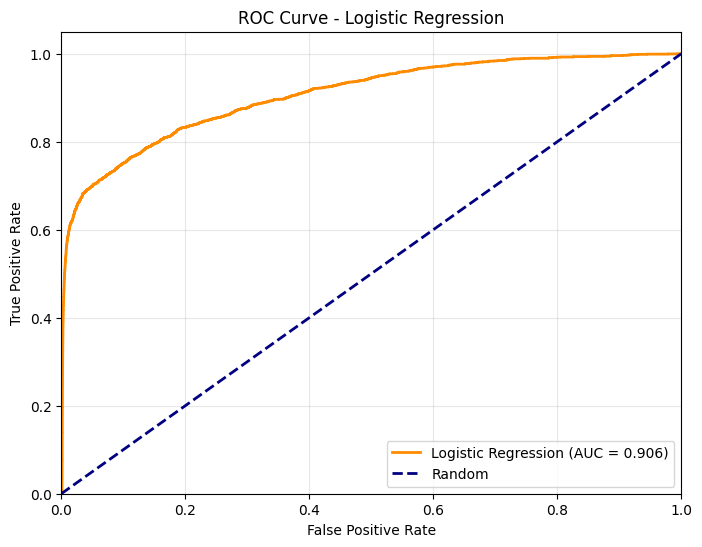

In [ ]:
# Step 8: Plot the AUC curve
log_reg_trainer.plot_auc_curve(y_test, test_prob, title="Logistic Regression")

This AUC has area of 0.906, suggesting its superior performance over random guess. It also shows sharp increase of true positive rate with small increase of false positive rate as threshold increases. Even though this AUC suggests selecting higher threshold, we need to prirotize detecting spams and decrease false negative instead. Since we want to prioritize recall, we should choose relatively lower threshold.

Computing SHAP values...


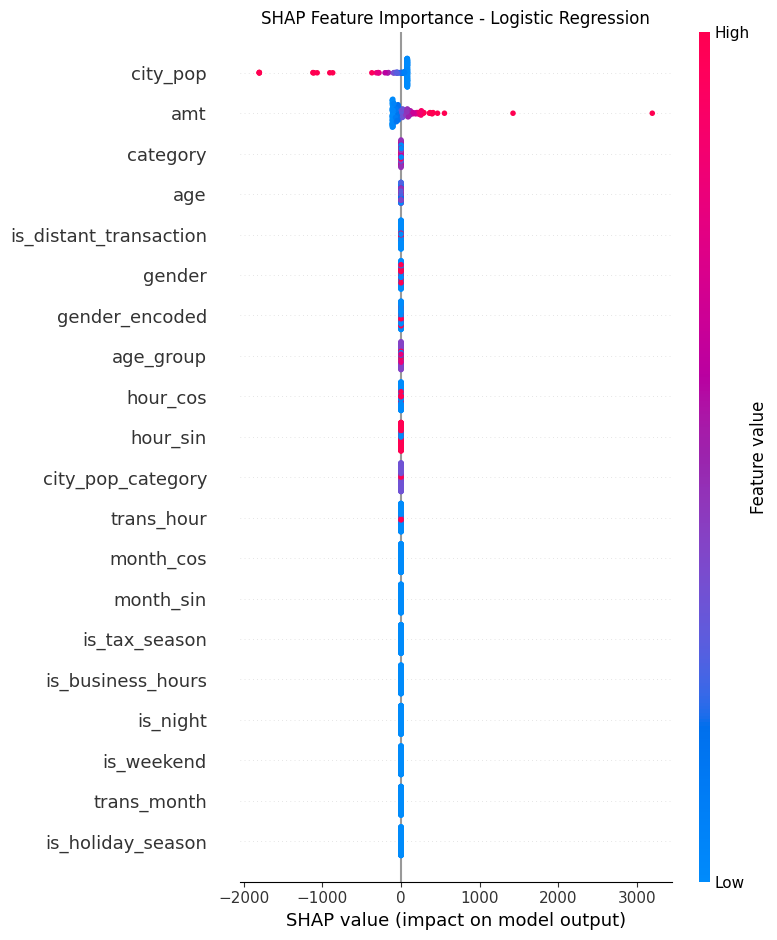

In [ ]:
# Step 9: Plot SHAP feature importance
feature_names = X_train.columns  # Replace with your feature names
log_reg_trainer.plot_shap_feature_importance(X_test, feature_names, max_display=20)

Based on the shap plot of the logistics regression model, feature 'amt' has relatively stronger positive and negative correlation with model's output. Even though some features have outliers with strong impacts, they do not form strong correlation with model's classification.
<br><br>
One thing worths noticing is that after tuning the model, the ranking of feature importance is very different.

## 7. Individual Model Training -- Random Forest

In [39]:
class RandomForestTrainer:
    """Random Forest trainer with modular steps for hyperparameter tuning, training, evaluation, and visualization"""

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.best_params = None

    def tune_hyperparameters(self, X_train, y_train, n_iter=20, cv_folds=3):
        """Step 1: Tune hyperparameters using RandomizedSearchCV"""
        print("Tuning hyperparameters for Random Forest...")
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.5],
            'class_weight': ['balanced', None]
        }
        model = RandomForestClassifier(random_state=self.random_state)
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grid, n_iter=n_iter, cv=cv_folds,
            scoring='f1', n_jobs=-1, random_state=self.random_state, verbose=1
        )
        random_search.fit(X_train, y_train)
        self.best_params = random_search.best_params_

        # Apply caps on `n_estimators` and `max_depth`
        self.best_params['n_estimators'] = min(self.best_params.get('n_estimators', 100), 100)  # Cap at 100 trees
        self.best_params['max_depth'] = min(self.best_params.get('max_depth', 10), 10)  # Cap depth at 10

        print(f"Best Parameters: {self.best_params}")
        return self.best_params

    def train(self, X_train, y_train):
        """Step 2: Train the model on the entire training dataset"""
        print("Training Random Forest on the full training dataset...")
        if self.best_params:
            self.model = RandomForestClassifier(random_state=self.random_state, **self.best_params)
        else:
            self.model = RandomForestClassifier(
                random_state=self.random_state, n_estimators=100, max_depth=10, class_weight='balanced'
            )
        self.model.fit(X_train, y_train)
        print("Model training complete.")

    def predict_on_test(self, X_test):
        """Step 3: Predict on test data"""
        if self.model is None:
            raise ValueError("Model is not trained yet! Please train the model before predicting.")
        
        print("Predicting on test data...")
        test_pred = self.model.predict(X_test)
        test_prob = self.model.predict_proba(X_test)[:, 1]
        return test_pred, test_prob

    def calculate_metrics(self, y_test, test_pred, test_prob):
        """Step 4: Calculate TP, FP, FN, TN and success metrics"""
        print("Calculating metrics...")
        cm = confusion_matrix(y_test, test_pred)
        tn, fp, fn, tp = cm.ravel()

        # Core metrics
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_precision = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)

        print(f"Metrics - Accuracy: {test_accuracy:.3f}, F1: {test_f1:.3f}, AUC: {test_auc:.3f}, "
              f"Precision: {test_precision:.3f}, Recall: {test_recall:.3f}")
        return {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'precision': test_precision,
            'recall': test_recall,
            'confusion_matrix': cm,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        }

    def display_classification_report(self, y_test, test_pred):
        """Step 5: Display sklearn's classification report and confusion matrix"""
        print("\nClassification Report:")
        print(classification_report(y_test, test_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, test_pred)
        print(cm)

    def plot_auc_curve(self, y_test, test_prob, title="Random Forest"):
        """Step 6: Plot the AUC curve"""
        print("Plotting AUC curve...")
        fpr, tpr, _ = roc_curve(y_test, test_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='green', lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {title}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_feature_importance(self, feature_names, max_display=20):
        """Plot feature importance using Random Forest's built-in feature importance"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        try:
            print("Plotting feature importance...")
            # Get feature importances from the model
            importances = self.model.feature_importances_
            indices = np.argsort(importances)[::-1]  # Sort in descending order
            top_indices = indices[:max_display]  # Select top features

            # Plot the feature importances
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(top_indices)), importances[top_indices], align="center", color="skyblue")
            plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
            plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
            plt.xlabel("Feature Importance")
            plt.title("Top Feature Importances - Random Forest")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Feature importance plotting failed: {e}")

In [40]:
# Initialize the RandomForestTrainer
rf_trainer = RandomForestTrainer(random_state=42)

In [ ]:
# Step 1: Tune hyperparameters
# best_params = rf_trainer.tune_hyperparameters(X_train_balanced, y_train_balanced)

In [42]:
# Step 2: Train the model
rf_trainer.train(X_train_balanced, y_train_balanced)

Training Random Forest on the full training dataset...
Model training complete.


In [44]:
# Step 4: Calculate metrics
metrics = rf_trainer.calculate_metrics(y_test, test_pred, test_prob)

Calculating metrics...
Metrics - Accuracy: 0.929, F1: 0.072, AUC: 0.906, Precision: 0.038, Recall: 0.722


In [45]:
# Step 5: Display classification report
rf_trainer.display_classification_report(y_test, test_pred)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.04      0.72      0.07      2145

    accuracy                           0.93    555719
   macro avg       0.52      0.83      0.52    555719
weighted avg       1.00      0.93      0.96    555719


Confusion Matrix:
[[514523  39051]
 [   596   1549]]


Random forest model produces almost identical result as the logistics regression, we can proceed with our analysis.

Plotting AUC curve...


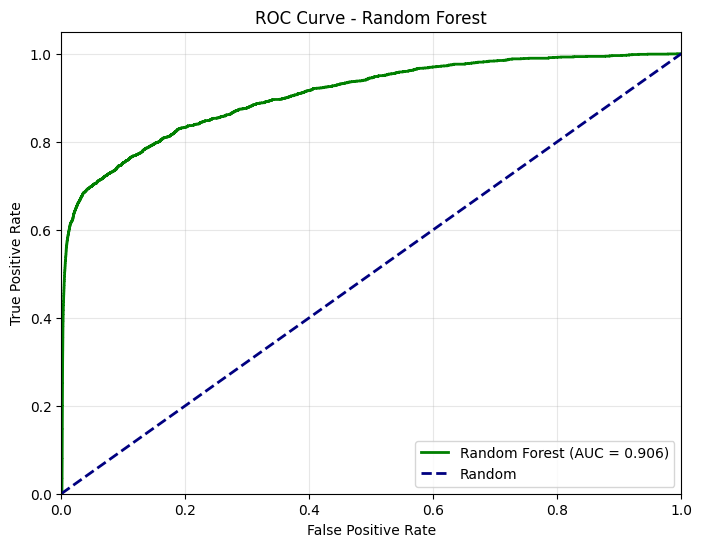

In [46]:
# Step 6: Plot AUC curve
rf_trainer.plot_auc_curve(y_test, test_prob)

We have the same AUC curve as logistics regression from random forest model as well.

Plotting feature importance...


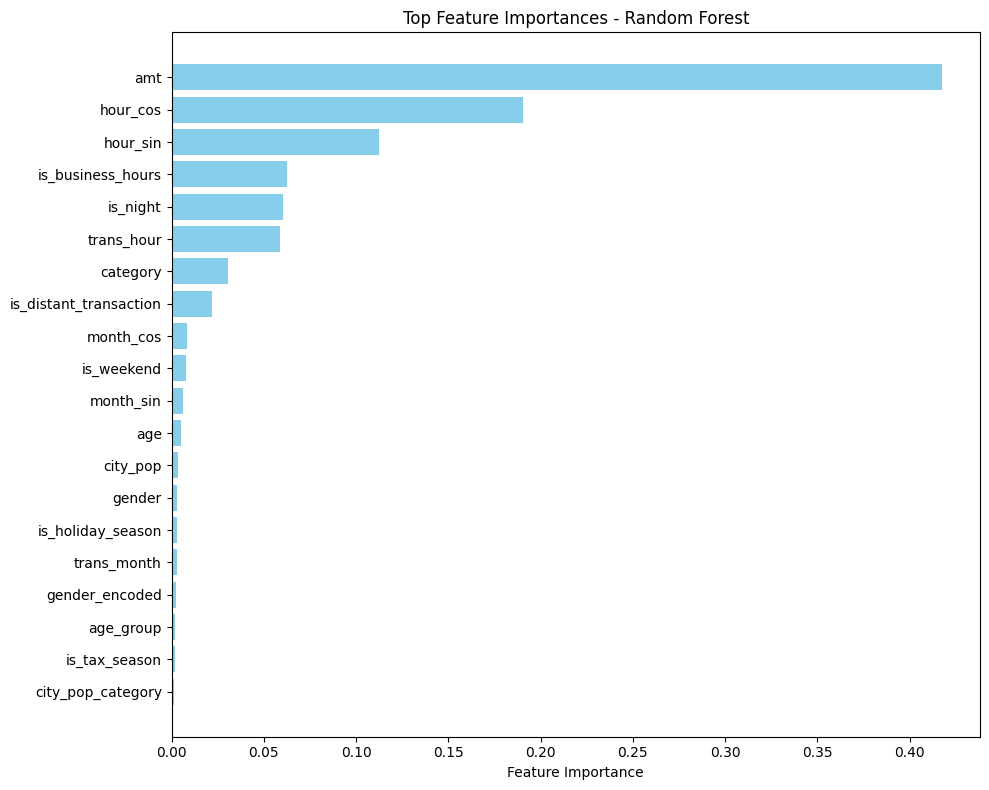

In [47]:
# Step 7: Plot feature importance
rf_trainer.plot_feature_importance(feature_names=X_train.columns, max_display=20)

Random forest model, ranks feature importance a little different than logistics model. Feature 'amt' is still top dominant in affecting model's output, but other strong features are time-related insetad of distance-based.

## 8. Individual Model Training -- XGBoost

In [48]:
class XGBoostTrainer:
    """XGBoost trainer with modular steps for hyperparameter tuning, training, evaluation, and visualization"""

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.cv_scores = []
        self.cv_auc_scores = []

    def tune_hyperparameters(self, X_train, y_train, n_iter=20, cv_folds=3):
        """Step 1: Tune hyperparameters using RandomizedSearchCV"""
        print("Tuning hyperparameters for XGBoost...")
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 5, 10],
            'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]
        }
        model = XGBClassifier(random_state=self.random_state, eval_metric='logloss', verbosity=0)
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grid, n_iter=n_iter, cv=cv_folds,
            scoring='f1', n_jobs=-1, random_state=self.random_state, verbose=1
        )
        random_search.fit(X_train, y_train)
        self.best_params = random_search.best_params_
        print(f"Best Parameters: {self.best_params}")
        return self.best_params

    def train_and_validate(self, X_train, y_train, k_folds=3):
        """Step 2: Train the model using k-fold cross-validation"""
        print(f"Training XGBoost with {k_folds}-fold cross-validation...")
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=self.random_state)
        self.cv_scores = []
        self.cv_auc_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Use best parameters if available
            if self.best_params:
                self.model = XGBClassifier(random_state=self.random_state, eval_metric='logloss', verbosity=0, **self.best_params)
            else:
                self.model = XGBClassifier(random_state=self.random_state, eval_metric='logloss', verbosity=0)

            self.model.fit(X_fold_train, y_fold_train)

            # Validate on the validation set
            val_pred = self.model.predict(X_fold_val)
            val_prob = self.model.predict_proba(X_fold_val)[:, 1]

            fold_f1 = f1_score(y_fold_val, val_pred)
            fold_auc = roc_auc_score(y_fold_val, val_prob)
            self.cv_scores.append(fold_f1)
            self.cv_auc_scores.append(fold_auc)

            print(f"  Fold {fold + 1}: F1={fold_f1:.3f}, AUC={fold_auc:.3f}")

        print(f"\nAverage F1 Score: {np.mean(self.cv_scores):.3f}")
        print(f"Average AUC Score: {np.mean(self.cv_auc_scores):.3f}")

    def predict_on_test(self, X_test):
        """Step 3: Predict on test data"""
        if self.model is None:
            raise ValueError("Model is not trained yet!")
        print("Predicting on test data...")
        test_pred = self.model.predict(X_test)
        test_prob = self.model.predict_proba(X_test)[:, 1]
        return test_pred, test_prob

    def calculate_metrics(self, y_test, test_pred, test_prob):
        """Step 4: Calculate TP, FP, FN, TN and success metrics"""
        print("Calculating metrics...")
        cm = confusion_matrix(y_test, test_pred)
        tn, fp, fn, tp = cm.ravel()

        # Core metrics
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_precision = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)

        print(f"Metrics - Accuracy: {test_accuracy:.3f}, F1: {test_f1:.3f}, AUC: {test_auc:.3f}, "
              f"Precision: {test_precision:.3f}, Recall: {test_recall:.3f}")
        return {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'precision': test_precision,
            'recall': test_recall,
            'confusion_matrix': cm,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        }

    def display_classification_report(self, y_test, test_pred):
        """Step 5: Display sklearn's classification report and confusion matrix"""
        print("\nClassification Report:")
        print(classification_report(y_test, test_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, test_pred)
        print(cm)

    def plot_auc_curve(self, y_test, test_prob, title="XGBoost"):
        """Step 6: Plot the AUC curve"""
        print("Plotting AUC curve...")
        fpr, tpr, _ = roc_curve(y_test, test_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {title}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_shap_feature_importance(self, X_test, feature_names, max_display=20):
        """Step 7: Plot SHAP feature importance"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        if not SHAP_AVAILABLE:
            print("SHAP not available. Skipping SHAP analysis.")
            return None

        try:
            print("Computing SHAP values...")
            explainer = shap.TreeExplainer(self.model)
            shap_values = explainer.shap_values(X_test[:200])  # Analyze subset for efficiency

            # Summary plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test[:200], feature_names=feature_names, max_display=max_display, show=False)
            plt.title('SHAP Feature Importance - XGBoost')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"SHAP analysis failed: {e}")

In [49]:
# Initialize the trainer
xgb_trainer = XGBoostTrainer(random_state=42)

In [50]:
# Step 1: Tune hyperparameters
best_params = xgb_trainer.tune_hyperparameters(X_train, y_train)

Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 171.75179856115108, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 171.75179856115108, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}


In [51]:
# Step 2: Train and validate
# Ensure X_train and y_train are numpy arrays for correct indexing in train_and_validate
xgb_trainer.train_and_validate(X_train.values, y_train.values, k_folds=5)

Training XGBoost with 5-fold cross-validation...
  Fold 1: F1=0.891, AUC=0.998
  Fold 1: F1=0.891, AUC=0.998
  Fold 2: F1=0.885, AUC=0.999
  Fold 2: F1=0.885, AUC=0.999
  Fold 3: F1=0.891, AUC=0.998
  Fold 3: F1=0.891, AUC=0.998
  Fold 4: F1=0.890, AUC=0.998
  Fold 4: F1=0.890, AUC=0.998
  Fold 5: F1=0.887, AUC=0.998

Average F1 Score: 0.889
Average AUC Score: 0.998
  Fold 5: F1=0.887, AUC=0.998

Average F1 Score: 0.889
Average AUC Score: 0.998


In [52]:
# Step 3: Predict on test data
test_pred, test_prob = xgb_trainer.predict_on_test(X_test)

Predicting on test data...


In [53]:
# Step 4: Calculate metrics
metrics = xgb_trainer.calculate_metrics(y_test, test_pred, test_prob)

Calculating metrics...
Metrics - Accuracy: 0.999, F1: 0.801, AUC: 0.993, Precision: 0.834, Recall: 0.771


In [54]:
# Step 5: Display classification report
xgb_trainer.display_classification_report(y_test, test_pred)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.77      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.89      0.90    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[553244    330]
 [   491   1654]]


XGBoost trainer produces much stronger predictive performance on test data, with 0.83 precision rate and 0.77 recall rate. It has largely eliminated type I errors as well, which is also important in not misclassifying normal transactions to frauds, which can be problematic in real life.

Plotting AUC curve...


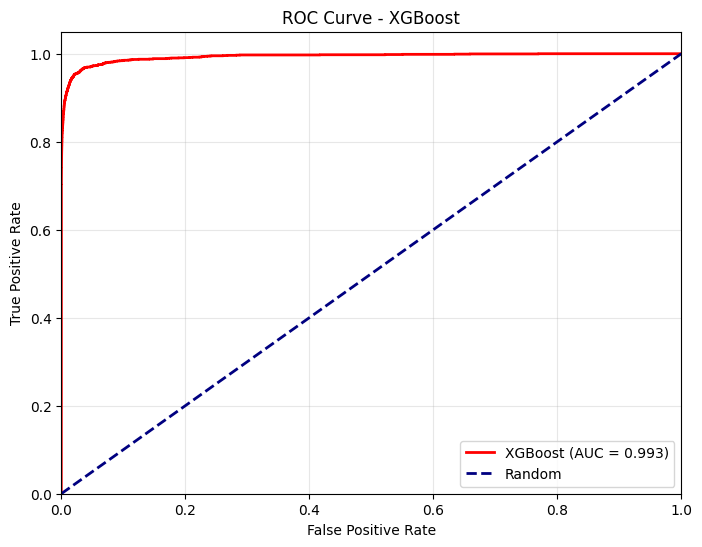

In [55]:
# Step 6: Plot AUC curve
xgb_trainer.plot_auc_curve(y_test, test_prob)

The AUC curve has area od 0.993, which is a significant improvement as it almost approaches 1, meaning it almost always catch ALL frauds across any false positive rates. In this case, we can choose higher threshold to decrease type I errors without compensating the cost of missing real frauds.

Computing SHAP values...


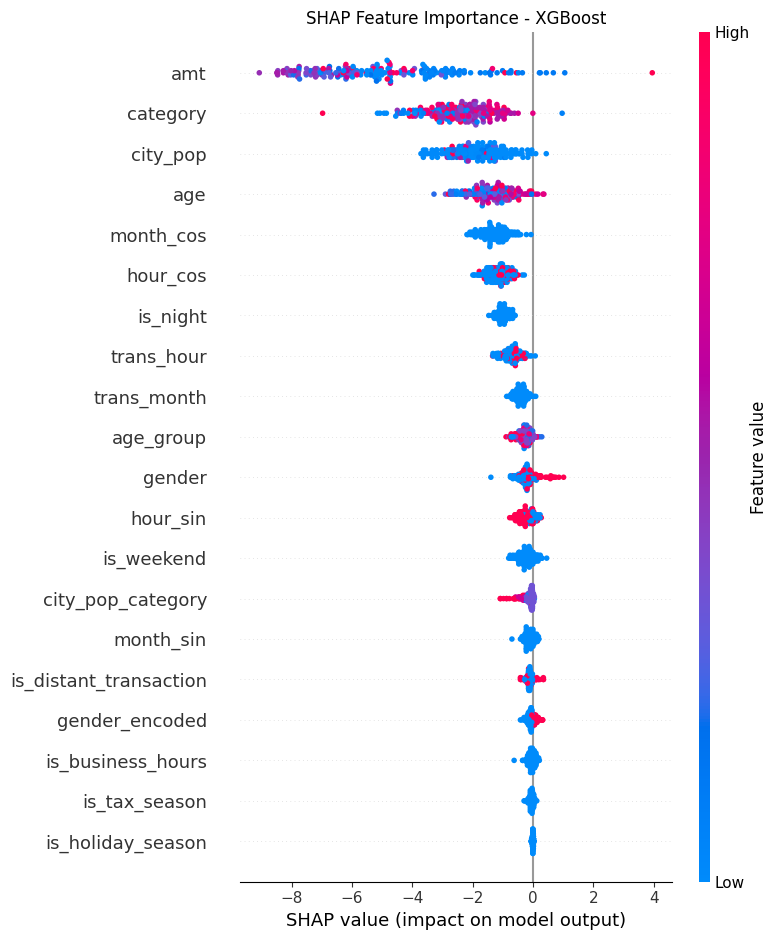

In [56]:
# Step 7: Plot SHAP feature importance
xgb_trainer.plot_shap_feature_importance(X_test, feature_names=X_train.columns)

According to SHAP plot produced by XGBoost trainer, 